In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Read in play-by-play data

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

nba_data = pd.read_csv('nba_pbp.csv')
#nba_data.tail(25)

Create dataframe for Game 6 of the 2016 Finals

In [3]:
game6 = nba_data[nba_data['Date']=='June 16 2016']
game6_scores = game6[(game6['ShotOutcome'] == 'make') | (game6['FreeThrowOutcome'] == 'make')]
game6_scores = game6_scores.dropna(subset=['HomePlay'])
game6_scores.reset_index(drop=True,inplace=True)
#game6_scores.head(10)

In [4]:
score_tracker = game6_scores.loc[:,['Quarter','SecLeft','AwayScore','HomePlay','HomeScore',
                                    'Shooter','ShotType','FreeThrowOutcome']]

In [5]:
fix_names = {'K. Irving - irvinky01':'K. Irving',
                 'L. James - jamesle01':'L. James',
                 'J. Smith - smithjr01':'J. Smith',
                 'R. Jefferson - jefferi01':'R. Jefferson',
                 'T. Thompson - thomptr01':'T. Thompson',
                 'M. Williams - willima01':'M. Williams',
                 'D. Jones - jonesda02':'D. Jones',
                 'K. Love - loveke01':'K. Love',
                 'M. Dellavedova - dellama01':'M. Dellavedova'}

In [6]:
score_tracker['Shooter'] = score_tracker['Shooter'].map(fix_names)
score_tracker['ShotType'] = score_tracker['ShotType'].str.split('-')
score_tracker

scoring = score_tracker.iloc[:,:]

Isolate Cavs scoring data

In [7]:
cavs = scoring.Shooter.unique().tolist()
cavs = cavs[1:]

def name_it(string):
    for name in cavs:
        a = string.split()
        b = ' '.join((a[0],a[1]))
        if name == b:
            return name
        
        
def get_pts(x):
    if type(x) == list:
        pts = x[0]
        return int(pts)
    
scoring['ShotType'] = scoring['ShotType'].apply(get_pts)
scoring['ShotType'] = scoring['ShotType'].fillna(1)
scoring['Player'] = scoring['HomePlay'].apply(name_it)

In [8]:
labels = ['M. Dellavedova',
               'R. Jefferson',
               'M. Williams',
               'D. Jones',
               'K. Love',
               'J. Smith',
               'T. Thompson',
               'K. Irving',
               'L. James']

In [9]:
pts = scoring.iloc[:,[8,6,4]]


pts

,Player,ShotType,HomeScore
0,L. James,1.0,1
1,T. Thompson,1.0,2
2,K. Irving,2.0,4
3,L. James,2.0,6
4,L. James,2.0,8
...,...,...,...
60,L. James,3.0,108
61,J. Smith,2.0,110
62,M. Williams,2.0,112
63,M. Dellavedova,1.0,113


In [10]:
shooter = pts.Player.values
point_value = pts.ShotType.values

scorer = list(zip(shooter,point_value))
print(scorer)

def score_parser(name,tups):
    pts_list = []
    for tup in tups:
        if tup[0] == name:
            pts_list.append(tup[1])
        else:
            pts_list.append(0)
    pts_list = np.cumsum(pts_list)        
    return pd.Series(pts_list)

[('L. James', 1.0), ('T. Thompson', 1.0), ('K. Irving', 2.0), ('L. James', 2.0), ('L. James', 2.0), ('K. Irving', 3.0), ('L. James', 2.0), ('J. Smith', 3.0), ('R. Jefferson', 2.0), ('K. Irving', 2.0), ('T. Thompson', 1.0), ('T. Thompson', 1.0), ('T. Thompson', 2.0), ('L. James', 2.0), ('M. Williams', 2.0), ('R. Jefferson', 1.0), ('T. Thompson', 2.0), ('K. Irving', 3.0), ('K. Love', 1.0), ('K. Irving', 2.0), ('K. Irving', 1.0), ('K. Irving', 1.0), ('T. Thompson', 2.0), ('K. Irving', 2.0), ('L. James', 3.0), ('K. Irving', 1.0), ('K. Irving', 1.0), ('K. Irving', 1.0), ('K. Irving', 1.0), ('T. Thompson', 2.0), ('L. James', 2.0), ('D. Jones', 2.0), ('D. Jones', 1.0), ('D. Jones', 1.0), ('D. Jones', 1.0), ('L. James', 2.0), ('K. Love', 1.0), ('J. Smith', 3.0), ('K. Love', 1.0), ('K. Love', 1.0), ('K. Love', 3.0), ('K. Irving', 2.0), ('L. James', 2.0), ('L. James', 2.0), ('L. James', 1.0), ('L. James', 3.0), ('L. James', 1.0), ('L. James', 1.0), ('L. James', 2.0), ('L. James', 2.0), ('L. Jame

In [11]:
labels

['M. Dellavedova',
 'R. Jefferson',
 'M. Williams',
 'D. Jones',
 'K. Love',
 'J. Smith',
 'T. Thompson',
 'K. Irving',
 'L. James']

Preprocess/Format scoring data for each Cavalier

In [12]:
jrs = score_parser('J. Smith',scorer)
kl = score_parser('K. Love',scorer)
md = score_parser('M. Dellavedova',scorer)
dj = score_parser('D. Jones',scorer)
mw = score_parser('M. Williams',scorer)
tt = score_parser('T. Thompson',scorer)
rj = score_parser('R. Jefferson',scorer)
ki = score_parser('K. Irving',scorer)
lbj = score_parser('L. James',scorer)

In [13]:
y = pd.concat([md,dj,mw,kl,tt,rj,jrs,ki,lbj],axis=1)
y.columns = labels


Create stacked area plot of Cavs scoring throughout the game

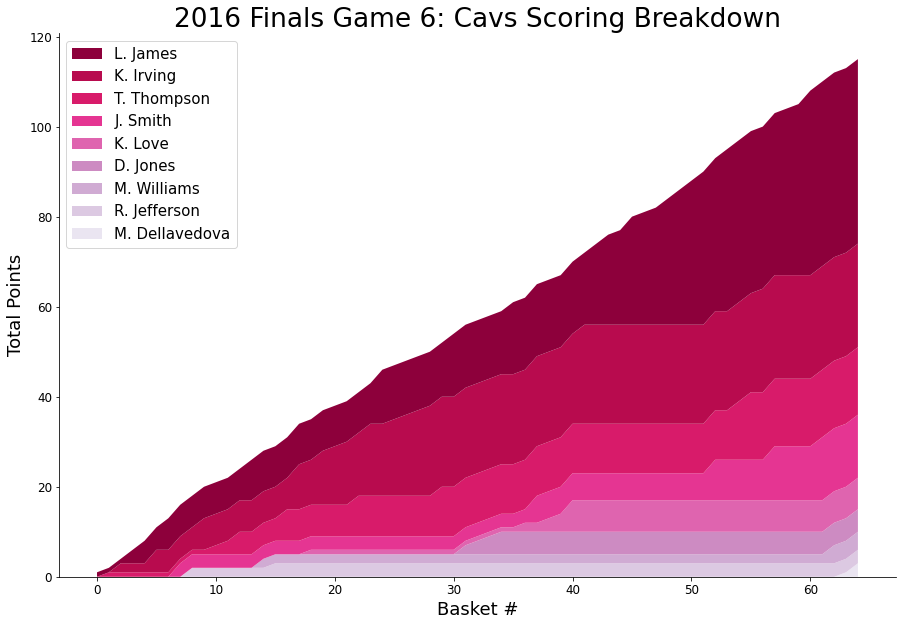

In [14]:
colormap = sns.color_palette('PuRd',9)

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=[15,10])
plt.stackplot(lbj.index,
              md.values,
              rj.values,
              mw.values,
              dj.values,
              kl.values,
              jrs.values,
              tt.values,
              ki.values,
              lbj.values,
              labels=labels,
              colors=colormap
              )
plt.legend(reversed(plt.legend().legendHandles),reversed(labels),loc='upper left',fontsize=15)
plt.title('2016 Finals Game 6: Cavs Scoring Breakdown')
plt.xlabel('Basket #',fontsize=18)
plt.ylabel('Total Points',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()



In [15]:
from pywaffle import Waffle

In [16]:
scoring_contributions = [md.values,
                         rj.values,
                         mw.values,
                         dj.values,
                         kl.values,
                         jrs.values,
                         tt.values,
                         ki.values,
                         lbj.values]


#data = {name:contribution for name,contribution in list(zip(labels,scoring_contributions))}
data = {'M. Dellavedova':3,
        'R. Jefferson':3,
        'M. Williams':4,
        'D. Jones':5,
        'K. Love':7,
        'J. Smith':14,
        'T. Thompson':15,
        'K. Irving':23,
        'L. James':41}

names_sorted = ['M. Dellavedova',
               'R. Jefferson',
               'M. Williams',
               'D. Jones',
               'K. Love',
               'J. Smith',
               'T. Thompson',
               'K. Irving',
               'L. James']
data

{'M. Dellavedova': 3,
 'R. Jefferson': 3,
 'M. Williams': 4,
 'D. Jones': 5,
 'K. Love': 7,
 'J. Smith': 14,
 'T. Thompson': 15,
 'K. Irving': 23,
 'L. James': 41}

Create waffle chart of scoring proportions

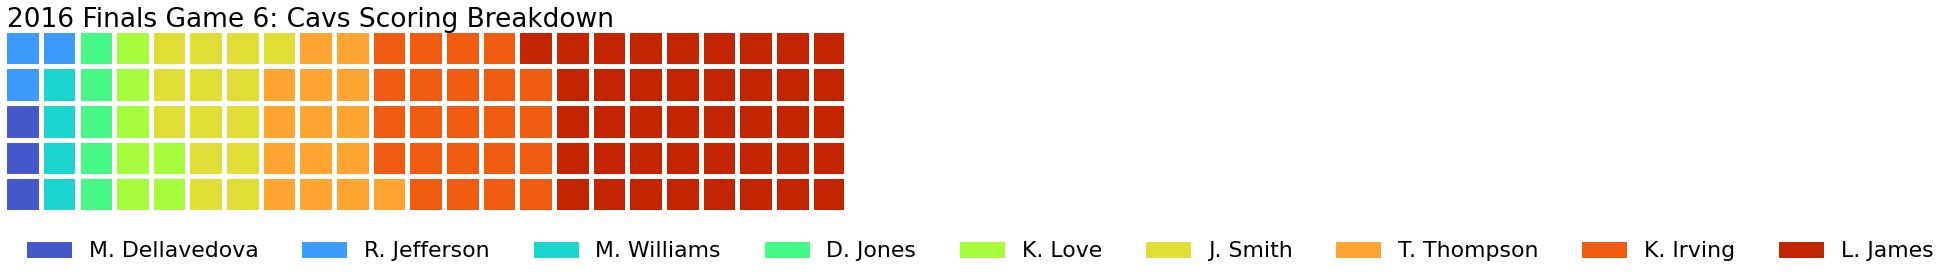

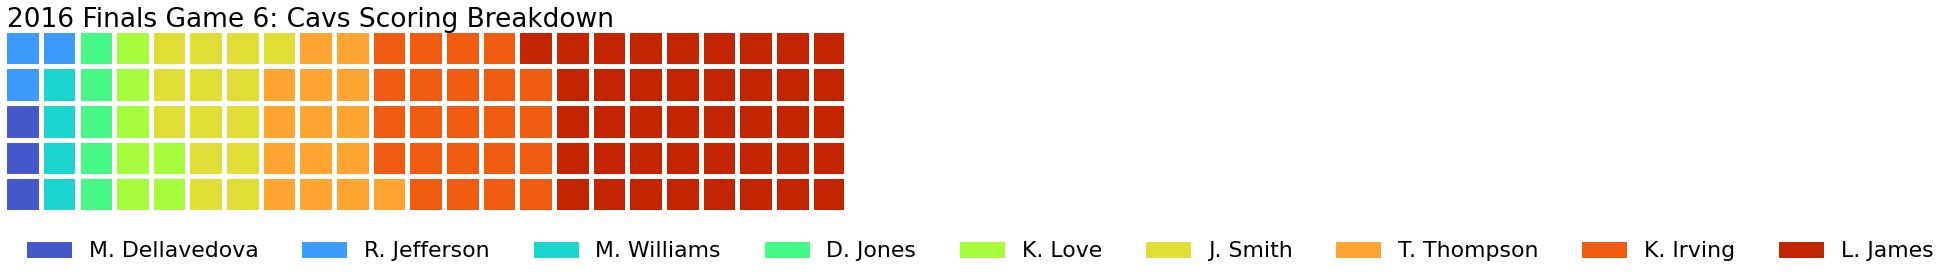

In [17]:
colormap2 = sns.color_palette('turbo',9)

plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=data, 
    colors=colormap2,
    title={'label': '2016 Finals Game 6: Cavs Scoring Breakdown', 'loc': 'left'},
    labels=names_sorted,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    starting_location='SW',
    block_arranging_style='snake',
    tight=False,
    figsize=(15, 10)
)

